# Preprocess Dataset
This page include the steps to load the original IMGUR5K Dataset which are in full page, extract the image based on words and save the word-based images for this research.

## Step 1. Load Original IMGUR5K Dataset

### 1.1 Get Dataset
1. Follow the instruction from [IMGUR5K Handwriting Dataset Repository](https://github.com/facebookresearch/IMGUR5K-Handwriting-Dataset) to collect the dataset.

2. Save to your local directory

### 1.2 Import Image Dataset

In [ ]:
import os

# Change to desired directory if needed
os.chdir('/save/to/path')

# Confirm it's changed
print("Current directory:", os.getcwd())

In [2]:
# your path to saved image dataset
image_dataset_path = "./dataset"

In [3]:
# load the dataset with image index
import os
import pandas as pd

def create_image_df():
    assert image_dataset_path is not None, "Set image dataset to the folder that include IMGUR5K Handwriting Dataset "
    # List to hold file names (without extensions)
    ids = []

    # Iterate over all files in the directory
    for filename in os.listdir(image_dataset_path):
        # Get the full path of the file
        full_path = os.path.join(image_dataset_path, filename)

        # Skip directories, only process files
        if os.path.isfile(full_path):
            # Split the filename into name and extension
            name, _ = os.path.splitext(filename)

            # Add the file name (without extension) to the list
            ids.append(name)

    # Create a DataFrame with two columns: ids and url
    df = pd.DataFrame({
        "id": ids
    })

    return df


# call function
df = create_image_df()

In [4]:
# overview of df
df.head()

,id
0,ONWVZrH
1,dRrGT11
2,5FD2oGX
3,SGND0Om
4,qWG1DMX


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_image(index):
    assert image_dataset_path is not None, "Set image dataset to the folder that include IMGUR5K Handwriting Dataset "
    path = image_dataset_path+"/"+ str(index) + '.jpg'
    img = Image.open(path).convert("RGB")
    # Display the image in a smaller size
    plt.figure(figsize=(10, 6))  # Adjust width and height in inches
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

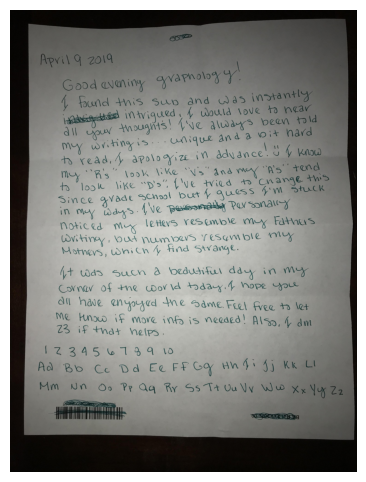

In [11]:
show_image("dRrGT11")

### 1.3 Label Ground Truth Text

In [14]:
import csv
# Get data infomation from the lst
data_info = './dataset/imgur5k_data.lst'

# Read url: actual url of the image
# Location: the location of the text based on the image
# text: Ground Truth Text
df_info = pd.read_csv(data_info, sep='\t', header=None, names=['url', 'location', 'text'], quoting=csv.QUOTE_NONE, )

# Extract the 'id' from the URL
df_info['id'] = df_info['url'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Reorder columns to match the desired output
df_info = df_info[['id', 'url', 'location', 'text']]

In [15]:
df = pd.merge(df, df_info, on='id', how='left')

In [16]:
df.head()

,id,url,location,text
0,ONWVZrH,https://i.imgur.com/ONWVZrH.jpg,"[2071.0, 1086.5, 4219.0, 1707.5, 3.0]",NeverLand
1,ONWVZrH,https://i.imgur.com/ONWVZrH.jpg,"[872.0, 94.0, 320.0, 190.0, 1.0]",.
2,dRrGT11,https://i.imgur.com/dRrGT11.jpg,"[388.67, 436.0, 289.0, 147.67, 0.33]",April
3,dRrGT11,https://i.imgur.com/dRrGT11.jpg,"[591.33, 438.0, 84.67, 130.67, 2.67]",9
4,dRrGT11,https://i.imgur.com/dRrGT11.jpg,"[786.0, 430.33, 245.67, 116.67, 5.0]",2019


In [17]:
df = df.dropna()

In [18]:
len(df)

227055

## Step 2. Extract Word Images from Full Images 

### 2.1 Cropping Each Word

In [19]:
# remove unrelated columns
df_words = df.drop(['url'], axis=1)

In [24]:
df_words.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227055 entries, 0 to 227084
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        227055 non-null  object
 1   location  227055 non-null  object
 2   text      227055 non-null  object
dtypes: object(3)
memory usage: 6.9+ MB


In [21]:
import math
import numpy as np

# gets the corner points of the rectangle
def get_rotated_rectangle_corners(xc, yc, w, h, a):
    # Convert angle to radians
    angle_rad = math.radians(a)
    cos_a = math.cos(angle_rad)
    sin_a = math.sin(angle_rad)

    # Unrotated corners relative to the center
    corners_relative = [
        (-w / 2, -h / 2),  # Top-left
        (w / 2, -h / 2),    # Top-right
        (w / 2, h / 2),     # Bottom-right
        (-w / 2, h / 2)      # Bottom-left
    ]

    # Rotate and translate corners
    corners = []
    for x, y in corners_relative:
        x_rot = x * cos_a - y * sin_a + xc
        y_rot = x * sin_a + y * cos_a + yc
        corners.append((x_rot, y_rot))

    # Reorder to left-top, right-top, right-bottom, left-bottom
    # The order is already correct as per the relative corners definition
    return np.array(corners)

In [22]:
import cv2
import numpy as np
import random


# gets the cropped, straightened image of the word at the specified location on the specified image
def normalized_words(image_path, xc, yc, w, h, angle) :
    # Open image with PIL first (as before)
    pil_image = Image.open(image_path)
    pil_image = pil_image.convert('RGB')
    pil_image_array = np.array(pil_image)
    
    # Convert PIL image to raw bytes
    _, img_bytes = cv2.imencode('.jpg', pil_image_array)  # Encode to raw byte array
    
    # Decode using OpenCV
    image = cv2.imdecode(img_bytes, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"[ERROR] OpenCV imdecode() failed to decode image: {image_path}")
    

    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    

    corners = get_rotated_rectangle_corners(xc, yc, w, h, -angle) # angle is negated to rotate according to this function
    corners = corners.astype(np.float32) # This line ensures corners are the correct data type
    
    # Define the width and height for the output image (you could compute this based on the rectangle size)
    width = int(np.linalg.norm(corners[0] - corners[1]))
    height = int(np.linalg.norm(corners[0] - corners[3]))
    
    # Define the destination points (the rectangle we want to map the original slanted rectangle to)
    dst_points = np.array([[0, 0], [width-1, 0], [width-1, height-1], [0, height-1]], dtype="float32")
    
    # Get the perspective transform matrix (tells how much to rotate the image)
    matrix = cv2.getPerspectiveTransform(corners, dst_points)
    
    # Apply the perspective transformation to get the cropped image
    cropped_image = cv2.warpPerspective(image, matrix, (width, height))
    
    return cropped_image # numpy array (width, height, rgb_channels)

In [40]:
import re

images = []  # reset just to be sure

for i, row in df.iloc[200000:].iterrows():
    image_path = image_dataset_path + '/' + row['id'] + '.jpg'
    word_location = row['location']
    matches = re.findall(r'\d+\.\d+', word_location)
    xc, yc, w, h, a = map(float, matches)

    # print(f"[{i}] ID: {row['id']}  |  Image path: {image_path}")

    cropped_image = normalized_words(image_path, xc, yc, w, h, a)
    images.append(cropped_image)
    if (i % 100) == 0:
        print(i)
    
    # print(i)

200100
200200
200300
200400
200500
200600
200700
200800
200900
201000
201100
201200
201300
201400
201500
201600
201700
201800
201900
202000
202100
202200
202300
202400
202500
202600
202700
202800
202900
203000
203100
203200
203300
203400
203500
203600
203700
203800
203900
204000
204100
204200
204300
204400
204500
204600
204700
204800
204900
205000
205100
205200
205300
205400
205500
205600
205700
205800
205900
206000
206100
206200
206300
206400
206500
206600
206700
206800
206900
207000
207100
207200
207300
207400
207500
207600
207700
207800
207900
208000
208100
208200
208300
208400
208500
208600
208700
208800
208900
209000
209100
209200
209300
209400
209500
209600
209700
209800
209900
210000
210100
210200
210300
210400
210500
210600
210700
210800
210900
211000
211100
211200
211300
211400
211500
211600
211700
211800
211900
212000
212100
212200
212300
212400
212500
212600
212700
212800
212900
213000
213100
213200
213300
213400
213500
213600
213700
213800
213900
214000
214100
214200
214300

In [41]:
len(images)
# images

27055

### 2.2 Save word-based Images as Slices Pickled File

In [42]:
# Slice the rows
df_subset = df_words.iloc[200000:]

# Convert each column to its own list
id_list = df_subset['id'].tolist()
text_list = df_subset['text'].tolist()
images_list = images

In [43]:
# Create the DataFrame
df_export = pd.DataFrame({
    'id': id_list,
    'text': text_list,
    'image': images_list  # Each row will hold a NumPy array
})

In [44]:
# save dataframe

import pickle
file_path = './dfwords_200000_227055.pkl'
with open('./dfwords_200000_227055.pkl', 'wb') as file:
    pickle.dump(df_export, file)

In [45]:
import pickle

with open('./dfwords_200000_227055.pkl', 'rb') as file:
    loaded_dfwords = pickle.load(file)

In [52]:
loaded_dfwords.info()
loaded_dfwords.iloc[27054]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27055 entries, 0 to 27054
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      27055 non-null  object
 1   text    27055 non-null  object
 2   image   27055 non-null  object
dtypes: object(3)
memory usage: 634.2+ KB


id                                                 SPQk0RG
text                                                    of
image    [[[183, 204, 212], [182, 203, 211], [182, 203,...
Name: 27054, dtype: object

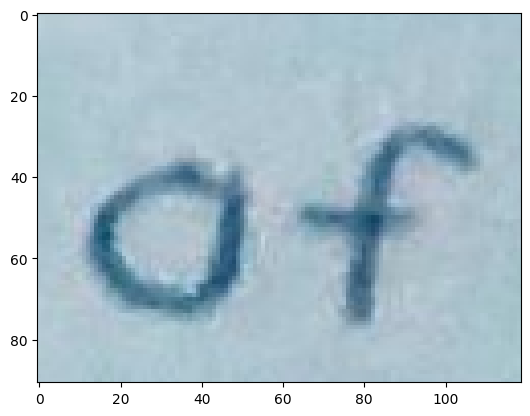

In [51]:
plt.imshow(loaded_dfwords.iloc[27054,2])
plt.show()

We have saved the slice image dataset as pickle files, the files should be as follows:
- dfwords_0_20000.pkl
- dfwords_20000_40000.pkl
- dfwords_40000_60000.pkl
- dfwords_60000_80000.pkl
- dfwords_80000_100000.pkl
- dfwords_100000_120000.pkl
- dfwords_120000_140000.pkl
- dfwords_140000_160000.pkl
- dfwords_160000_180000.pkl
- dfwords_180000_200000.pkl
- dfwords_200000_227055.pkl

Make sure the pickle files are saved in directory *dataset/stylized*